In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import gradio as gr
import tensorflow as tf
from tensorflow import keras 
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# Read in the Data

In [2]:
folder_benign_train = 'train/benign'
folder_malignant_train = 'train/malignant'

folder_benign_test = 'test/benign'
folder_malignant_test = 'test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

# Display Data

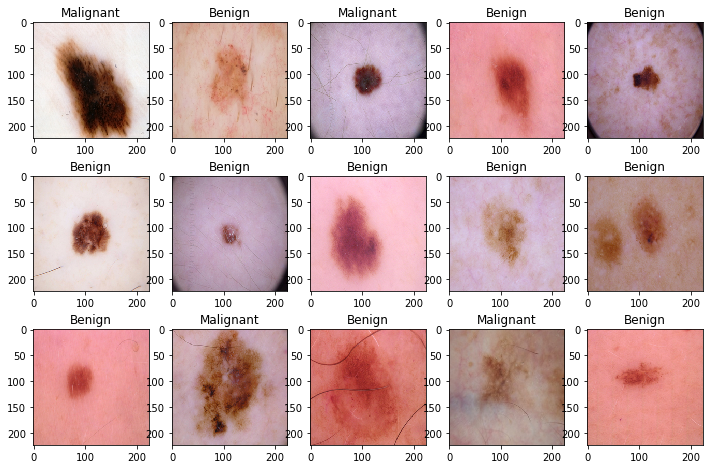

In [3]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()



# Dataset
The dataset is almost balanced. It has 1800 benign samples and 1497 malignant samples

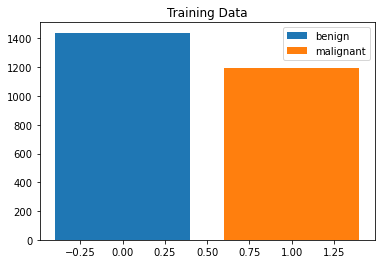

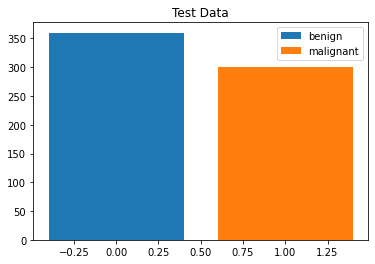

In [4]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()


# Preprocessing

In [5]:
train_datagen= ImageDataGenerator( rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True )
training_set=train_datagen.flow_from_directory('train',
                                                 target_size = (64, 64),
                                                 batch_size = 10,
                                                 class_mode = 'binary')

Found 2637 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('test',
                                            target_size = (64, 64),
                                            batch_size = 10,
                                            class_mode = 'binary')

Found 660 images belonging to 2 classes.


# Training Model

In [83]:
cnn=Sequential()
cnn.add(Conv2D(filters=32,kernel_size=3, activation='relu',input_shape=[64,64,3]))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(MaxPooling2D(pool_size=2,strides=2))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(MaxPooling2D(pool_size=2,strides=2))
cnn.add(Dropout(0.25))
# cnn.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
# cnn.add(LeakyReLU(alpha=0.1))
# cnn.add(MaxPooling2D(pool_size=2,strides=2))
# cnn.add(Dropout(0.3))
cnn.add(Flatten())
cnn.add(Dense(units=128,activation='relu'))
cnn.add(LeakyReLU(alpha=0.1))
cnn.add(Dropout(0.4))
cnn.add(Dense(units=1,activation='sigmoid'))

In [84]:
cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [85]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
#history = cnn.fit(x=training_set,validation_data=test_set,epochs=50, callbacks=[callback])
history = cnn.fit(x=training_set,validation_data=test_set,epochs=50)

Epoch 1/50
264/264 [==============================] - 16s 56ms/step - loss: 0.7699 - accuracy: 0.5948 - val_loss: 0.5281 - val_accuracy: 0.7485
Epoch 2/50
264/264 [==============================] - 16s 61ms/step - loss: 0.5178 - accuracy: 0.7509 - val_loss: 0.4120 - val_accuracy: 0.7894
Epoch 3/50
264/264 [==============================] - 16s 59ms/step - loss: 0.4646 - accuracy: 0.7806 - val_loss: 0.4455 - val_accuracy: 0.7758
Epoch 4/50
264/264 [==============================] - 16s 60ms/step - loss: 0.5203 - accuracy: 0.7336 - val_loss: 0.4079 - val_accuracy: 0.7939
Epoch 5/50
264/264 [==============================] - 16s 60ms/step - loss: 0.4219 - accuracy: 0.7872 - val_loss: 0.3794 - val_accuracy: 0.7894
Epoch 6/50
264/264 [==============================] - 16s 61ms/step - loss: 0.4018 - accuracy: 0.7984 - val_loss: 0.4186 - val_accuracy: 0.7667
Epoch 7/50
264/264 [==============================] - 17s 64ms/step - loss: 0.3946 - accuracy: 0.7994 - val_loss: 0.3553 - val_accuracy:

In [86]:
cnn.save("model.h5")

# Testing Model

In [87]:
test_loss, test_acc = cnn.evaluate(test_set, verbose=2)

66/66 - 1s - loss: 0.3460 - accuracy: 0.8348


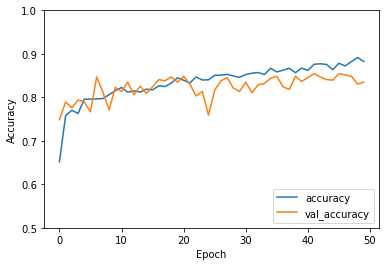

In [88]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

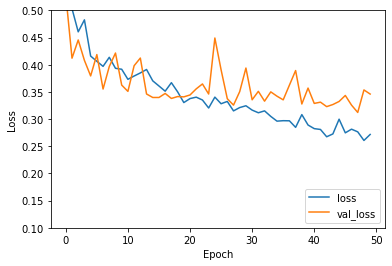

In [89]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.1, 0.5])
plt.legend(loc='lower right')

In [90]:
print(test_acc)

0.8348484635353088


# Predictions

In [7]:
print(training_set.class_indices)

{'benign': 0, 'malignant': 1}


In [8]:
model = load_model('model.h5')

In [12]:
test_image= image.load_img('test/malignant/3.jpg',target_size=(64,64))
test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
if result[0][0]==1:
    print('malignant')
else:
    print('benign')

malignant


In [13]:
test_image= image.load_img('test/benign/903.jpg',target_size=(64,64))
test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
if result[0][0]==1:
    print('malignant')
else:
    print('benign')

benign


# Interface

In [15]:
model = load_model('model.h5')
def skin_cancer(Input_Image):
    Input_Image=image.img_to_array(Input_Image)
    Input_Image=np.expand_dims(Input_Image,axis=0)
    result=model.predict(Input_Image)
    if result[0][0]==1:
        return('Malignant')
    else:
        return('Benign')
    

iface = gr.Interface(fn=skin_cancer, inputs = gr.inputs.Image(shape=(64, 64)), outputs="text")

iface.launch()

Running locally at: http://127.0.0.1:7861/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7861/', None)